In [2]:
import pandas as pd
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
def _read_pickle(file_name):
    return pd.read_pickle(file_name)

def read_data(file_name):
    
    df = _read_pickle(file_name)
    a = [] 
    for t in df:
        a.append(np.squeeze(t.numpy(), 0))

    return a


# Data Loading

In [4]:
train = torch.load('train_en_to_es_Translation_Helsinki_labse_bert_embedded.pkl')
#train = pd.read_csv('jigsaw_toxic-comment_train_embedded.pkl')
#train = pickle.load( open( 'jigsaw_toxic-comment_train_embedded.pkl', "rb" ) )

In [5]:
len(train)

20000

In [6]:
#val = torch.load('validation_es_only_text.pkl')
#val = pickle.load( open( 'validation_es_only_text.pkl', "rb" ) )
val = torch.load('val_es_text_only_labse_bert_embedded.pkl')
val = [x.numpy() for x in val]

In [7]:
train_path = '../../data/jigsaw-toxic-comment-train.csv'
val_path = '../../data/val_es_toxic.csv' 

In [8]:
train_set = pd.read_csv(train_path)
val_set = pd.read_csv(val_path)

In [9]:
from sklearn.model_selection import train_test_split
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(train, train_set.toxic[0:20000], test_size=0.33, random_state=42)

In [10]:
X_train_eng = np.squeeze(np.stack([x.numpy() for x in X_train_eng]))
X_test_eng = np.squeeze(np.stack([x.numpy() for x in X_test_eng]))
#val = np.squeeze(np.stack([x.numpy() for x in val]))

# Logistic regression

### Train - English only

In [11]:
%%time
pipe = make_pipeline(StandardScaler(), LogisticRegression( class_weight='balanced', max_iter=10000))
#pipe = make_pipeline(StandardScaler(), LogisticRegression( max_iter=1000))

pipe.fit(X_train_eng, y_train_eng)
#clf = LogisticRegression(random_state=0).fit(train[0:1000],list(val_set.toxic[0:1000]) )


CPU times: user 8.56 s, sys: 183 ms, total: 8.74 s
Wall time: 2.39 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=10000))])

In [12]:
import joblib

joblib.dump(pipe, "models/Logistic_Regression/logistic_regression_LABSE_embedded.pkl") 
joblib.dump(X_train_eng, "models/X_and_y/X_train_eng.pkl") 
joblib.dump(X_test_eng, "models/X_and_y/X_test_eng.pkl") 
joblib.dump(y_train_eng, "models/X_and_y/y_train_eng.pkl")
joblib.dump(y_test_eng, "models/X_and_y/y_test_eng.pkl")


['models/X_and_y/y_test_eng.pkl']

# MLP Classifier

### Train - English only

In [13]:
%%time

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=512, random_state=1, max_iter=300)

pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X_train_eng, y_train_eng)

CPU times: user 3min 7s, sys: 8.21 s, total: 3min 15s
Wall time: 49.1 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=512, max_iter=300,
                               random_state=1))])

In [14]:
joblib.dump(pipe, "models/MLP_Classifier/MLP_Classifier_LABSE_embedded.pkl") 


['models/MLP_Classifier/MLP_Classifier_LABSE_embedded.pkl']

# Neural Network

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models

class net(nn.Module):

    def __init__(self):

        super(net, self).__init__()
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        # relu activation function
        self.relu =  nn.ReLU()
        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)
    
    #define the forward pass
    def forward(self, in_vec):
        
        #pass the inputs to the model  
        x = self.fc1(in_vec)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)

        return x

In [16]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(y_train_eng), y_train_eng)

print("Class Weights:",class_weights)



Class Weights: [0.55390212 5.13803681]


/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=7070     0
13010    0
6688     0
9976     0
5175     0
        ..
11284    0
11964    0
5390     0
860      0
15795    0
Name: toxic, Length: 13400, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [17]:
import time
import copy

train_loss = []
train_con = []

eval_loss = []
eval_con = []

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            i = 0 
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    #print(outputs, labels)

                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer


                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()
 

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            #writer.add_histogram("conv1.weight_hist", model.conv1.weight, epoch)
            #writer.add_histogram("conv1.weight_avg", model.conv1.weight.mean(), epoch)
            #writer.add_histogram("model_loss", loss.item(), epoch)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_con.append(epoch_acc)
                i += 1
                #writer.add_scalar('training loss', running_loss / 1000, epoch * len(dataloaders['train']) + i) 
            if phase == 'val':
                eval_loss.append(epoch_loss)
                eval_con.append(epoch_acc)
                i += 1
                #writer.add_scalar('eval loss', running_loss / 1000, epoch * len(dataloaders['train']) + i) 
                #print("pred {0} lable: {1}".format(preds, labels.data))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'saved_weights.pt')
    return model, train_loss, train_con, eval_loss, eval_con

In [18]:
from transformers import AdamW

model = net()
model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

my_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
import torch.utils.data as data_utils

tensor_x_train = torch.from_numpy(np.array(X_train_eng)) # transform to torch tensor
tensor_y_train = torch.from_numpy(np.array(y_train_eng))

tensor_x_val = torch.from_numpy(np.array(X_test_eng)) # transform to torch tensor
tensor_y_val = torch.from_numpy(np.array(y_test_eng))

datasets = {'train':data_utils.TensorDataset(tensor_x_train, tensor_y_train) ,'val':data_utils.TensorDataset(tensor_x_val, tensor_y_val)  }


dataloaders_my = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=16,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(datasets['val'], batch_size=16,
                                          shuffle=False, num_workers=2)
  }

# Train - English only

In [20]:
%%time

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

train_loss = []
train_con = []

eval_loss = []
eval_con = []

num_epochs=10
#inputs, labels = inputs.to(device), labels.to(device)

model, train_loss, train_con, eval_loss, eval_con  = train_model(model, 
                    dataloaders_my,
                       cross_entropy, 
                       optimizer, 
                       my_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.5662 Acc: 0.8607
val Loss: 0.4784 Acc: 0.8980

Epoch 1/9
----------
train Loss: 0.4231 Acc: 0.8915
val Loss: 0.3830 Acc: 0.8892

Epoch 2/9
----------
train Loss: 0.3587 Acc: 0.8850
val Loss: 0.3448 Acc: 0.8811

Epoch 3/9
----------
train Loss: 0.3309 Acc: 0.8840
val Loss: 0.3286 Acc: 0.8845

Epoch 4/9
----------
train Loss: 0.3133 Acc: 0.8857
val Loss: 0.3202 Acc: 0.8915

Epoch 5/9
----------
train Loss: 0.3039 Acc: 0.8878
val Loss: 0.3150 Acc: 0.8835

Epoch 6/9
----------
train Loss: 0.2992 Acc: 0.8886
val Loss: 0.3121 Acc: 0.8921

Epoch 7/9
----------
train Loss: 0.2919 Acc: 0.8944
val Loss: 0.3118 Acc: 0.8917

Epoch 8/9
----------
train Loss: 0.2934 Acc: 0.8927
val Loss: 0.3114 Acc: 0.8902

Epoch 9/9
----------
train Loss: 0.2951 Acc: 0.8919
val Loss: 0.3113 Acc: 0.8926

Training complete in 0m 35s
Best val Acc: 0.898030
CPU times: user 28.1 s, sys: 5 s, total: 33.1 s
Wall time: 34.6 s


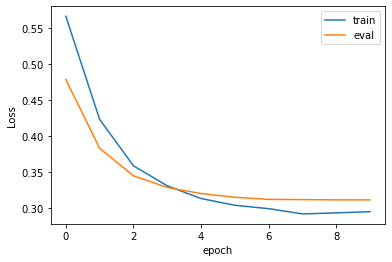

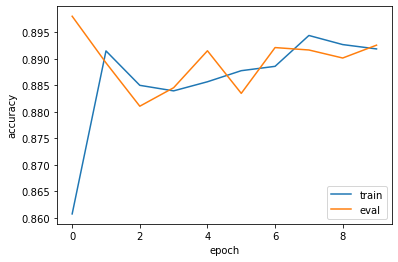

In [21]:
plt.figure(1)
plt.plot(train_loss, label='train')
plt.plot(eval_loss, label='eval')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()

plt.figure(2)
plt.plot(train_con, label='train')
plt.plot(eval_con, label='eval')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()
plt.show()